# Generate scatterplots and tables of CP 1/2/3 mutated position proportions in genes

The goal is showing "outlier" genes with particularly high mutation rates.

In [1]:
%run "Header.ipynb"
%run "LoadMutationJSONData.ipynb"
%run "GeneUtils.ipynb"

In [2]:
from parse_sco import parse_sco

def gene_scatterplot_maker(pseudo_variant_caller, output_dict=False, seq2genes_to_highlight={}):
    """Shows scatterplots of mutated position proportions in the 1st, 2nd, and 3rd positions of predicted genes.

    Parameters
    ----------
    pseudo_variant_caller: function
        Works similarly to histogram_maker().
        Takes as input two parameters:
            1. cov: an integer describing number of reads aligned to a position (just matches & mismatches)
            2. mismatchct: an integer describing the number of matching reads aligned to a position
            
        Should return a number: 1 if a position is "mutated", 0 if not mutated. Yeah, ideally this would
        return a bool, but numbers make this easier.
        
        We guarantee that cov will be > 0 when this is called -- for positions where cov <= 0, this'll just
        automatically call this position as not mutated.
        
    seq2genes_to_highlight: dict
        Maps sequence names to a dict mapping gene numbers (as ints) to hex colors.
        Selected genes will be enlarged in scatterplots and colored accordingly, so that they can be visually
        emphasized.
    """
    max_cp1_nm = 0
    max_cp2_nm = 0
    max_cp3_nm = 0
    seq2gene2normalizedmutct = {}
    for seq in SEQS:
        df = parse_sco("../seqs/genes/{}.sco".format(seq))
        # Go through each gene in this sequence, and compute the (normalized) mutated-position frequency at
        # each of its three codon positions.
        seq2gene2normalizedmutct[seq] = {}
        for gene in df.itertuples():
            i = 1
            cp1_mutct = 0
            cp2_mutct = 0
            cp3_mutct = 0
            for pos in get_pos_interval_from_gene(gene):
                val = get_val(seq, pos, pseudo_variant_caller)
                if val not in [0, 1]:
                    raise ValueError("Output of pseudo_variant_caller should just be an 0 or 1.")
                if i == 1:
                    cp1_mutct += val
                    i = 2
                elif i == 2:
                    cp2_mutct += val
                    i = 3
                elif i == 3:
                    cp3_mutct += val
                    i = 1
                else:
                    raise ValueError("Codon position modulo calculation is broken :|")

            if i != 1:
                raise ValueError("Gene length not divisible by 3.")

            onethirdlen = gene.Length / 3
            nm1 = cp1_mutct / onethirdlen
            nm2 = cp2_mutct / onethirdlen
            nm3 = cp3_mutct / onethirdlen
            seq2gene2normalizedmutct[seq][gene.Index] = [nm1, nm2, nm3]
            # Try to update maxima
            max_cp1_nm = max(max_cp1_nm, nm1)
            max_cp2_nm = max(max_cp2_nm, nm2)
            max_cp3_nm = max(max_cp3_nm, nm3)

    # Only do plotting after we've seen all genes in all sequences. This ensures that we know the maximum
    # fraction of (mutated positions / one third gene length) across all CPs in all genes in all sequences.
    # (I mean, the theoretical maximum of this is just 1, in the case where all positions in a CP in a gene
    # are mutated... but that PROBABLY won't happen unless there are some really tiny and/or wacky genes)
    max_cp_nm = max(max_cp1_nm, max_cp2_nm, max_cp3_nm)
    
    
    # Compute scatterplots for CP 1 vs. CP 2 mutated-position frequencies for all genes
    # within this sequence
    def show_cp_vs_cp_plot(seq, x_cp, y_cp, axes):
        """x_cp and y_cp should be 1-indexed CP numbers (one of [1, 2, 3])."""
        if x_cp not in [1,2,3] or y_cp not in [1,2,3]:
            raise ValueError("CPs must be one of [1, 2, 3].")
            
        gene_normalizedmutcts = seq2gene2normalizedmutct[seq].values()
        
        axes.set_title('{}: CP {} vs. CP {}'.format(seq2name[seq], x_cp, y_cp))
        axis_label = "Normalized number of mutated positions in CP {}"
        axes.set_xlabel(axis_label.format(x_cp))
        axes.set_ylabel(axis_label.format(y_cp))
        
        # This is the default size of scatterplot points in matplotlib: see the "s" param docs
        # at https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html.
        dflt_size = (matplotlib.rcParams["lines.markersize"] ** 2)
        
        for gene in seq2gene2normalizedmutct[seq].keys():
            if seq in seq2genes_to_highlight and gene in seq2genes_to_highlight[seq]:
                color = seq2genes_to_highlight[seq][gene]
                # Double "size" of highlighted genes. There is a bit of ambiguity as to what exactly
                # "size" means (area?) -- see https://stackoverflow.com/a/47403507. Rather than spending 30
                # minutes doing a deep dive into this I'm just gonna multiply by four and call it a day
                size = 4 * dflt_size
            else:
                color = SCATTERPLOT_PT_COLOR
                size = dflt_size
            axes.scatter(
                seq2gene2normalizedmutct[seq][gene][x_cp - 1],
                seq2gene2normalizedmutct[seq][gene][y_cp - 1],
                c=color,
                s=size
            )
        
        axes.set_xlim(0, max_cp_nm)
        axes.set_ylim(0, max_cp_nm)
        
        # Plot diagonal line: https://stackoverflow.com/a/22105008
        # Get "ax": https://stackoverflow.com/a/15067854
        axes.plot(axes.get_xlim(), axes.get_ylim(), ls="--", c=".3")
        
        # Make figure square
#         fig = matplotlib.pyplot.gcf()
#         fig.set_size_inches(6, 6)
        
#         pyplot.show()
    
    # Tile the scatterplots in a grid
    fig, axes = pyplot.subplots(2, 3, gridspec_kw={"hspace": 0.3, "wspace": 0.3})
    for i, seq in enumerate(SEQS):
        show_cp_vs_cp_plot(seq, 1, 2, axes[0, i])        
        show_cp_vs_cp_plot(seq, 1, 3, axes[1, i])
    
    fig.suptitle(
        "Frequencies of mutated positions across genes' CPs",
        fontsize="15",
        y=0.93
    )
    fig.set_size_inches(18, 12)
    fig.savefig("figs/outlier-gene-scatterplots.png", bbox_inches="tight")
        
    if output_dict:
        return seq2gene2normalizedmutct

Found position with 0 mismatches or matches in edge_1671: pos=1198066 (assigning value of 0)
Found position with 0 mismatches or matches in edge_1671: pos=1198067 (assigning value of 0)
Found position with 0 mismatches or matches in edge_1671: pos=1198068 (assigning value of 0)
Found position with 0 mismatches or matches in edge_1671: pos=1198069 (assigning value of 0)
Found position with 0 mismatches or matches in edge_1671: pos=1198070 (assigning value of 0)
Found position with 0 mismatches or matches in edge_1671: pos=1198071 (assigning value of 0)
Found position with 0 mismatches or matches in edge_1671: pos=1198075 (assigning value of 0)
Found position with 0 mismatches or matches in edge_1671: pos=1198076 (assigning value of 0)
Found position with 0 mismatches or matches in edge_1671: pos=1198077 (assigning value of 0)
Found position with 0 mismatches or matches in edge_1671: pos=1198078 (assigning value of 0)
Found position with 0 mismatches or matches in edge_1671: pos=1198079 

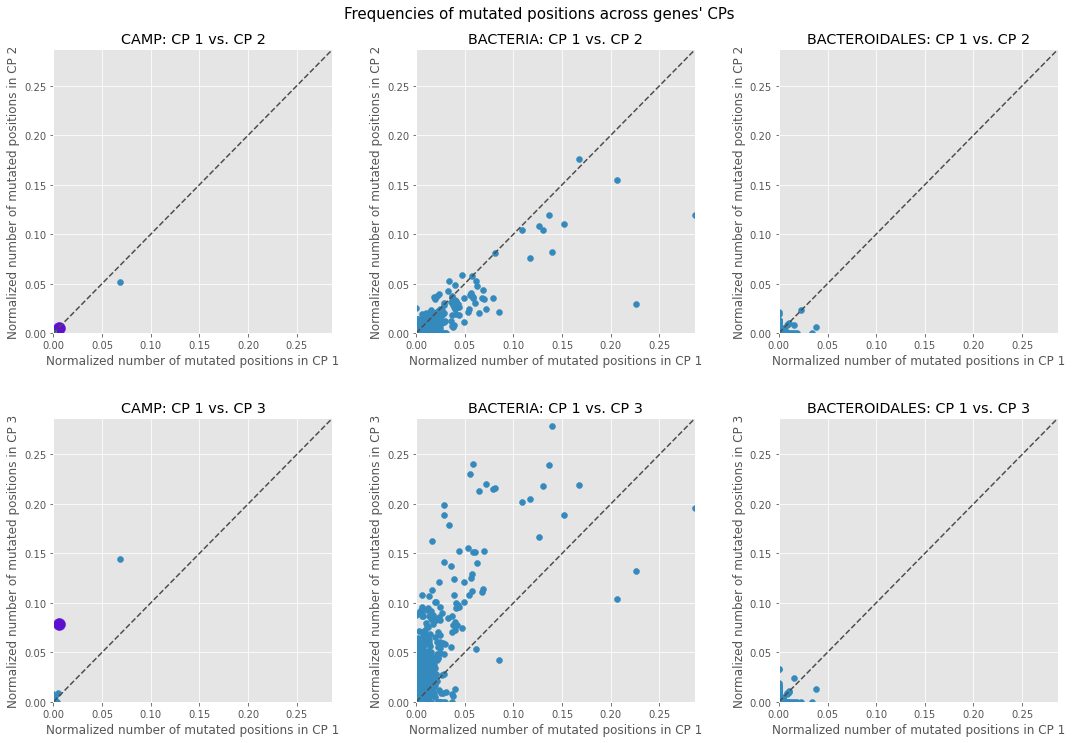

In [3]:
seq2gene2normalizedmutct = gene_scatterplot_maker(
    # This means that minfreq = 0.5%
    lambda cov, mismatches: 1 if (mismatches / cov) > 0.005 else 0,
    True,
    # Gene 1217 (left end 1,208,927; right end 1,210,075) is "G1" in the manuscript [colored purple here]
    # Gene  206 (left end   198,794; right end   200,347) is "G2" in the manuscript [colored golden-ish here]
    {"edge_6104": {1217: "#5F0FCF", 206: "#E0A000"}},
)

In [4]:
# Focus on specific outlier genes in CAMP, manually... (ideally this would be paired with interactive plots
# using Altair or something but installing that is hard)
seq = "edge_6104"
for gene in seq2gene2normalizedmutct[seq]:
    if seq2gene2normalizedmutct[seq][gene][2] > 0.05:
        print(gene, seq2gene2normalizedmutct[seq][gene])

970 [0.0683111954459203, 0.051233396584440226, 0.1442125237191651]
1217 [0.005221932114882507, 0.005221932114882507, 0.0783289817232376]


## Highly Mutated Gene Tables

- For every sequence:
  - Initialize a list that we'll use to store "gene" objects. These can just be stored as dicts.
  - For every gene in this sequence:
    - Store "number of mutated positions", "number of nonsynonymous mutated positions"
    - For every position in this gene:
      - See if this position is mutated (> 0.5% mutation rate; same as elsewhere in the code)
      - If this position is mutated:
        - Increment number of mutated positions
        - Get the codon of this position (will depend on gene being on +/- strand). Call it "C1".
        - Look at `seq2pos2mismatches` JSON for this sequence and position. Get the maximum-frequency alternate nucleotide (__we could change this behavior if desired__).
        - Change the codon of this position, substituting the max-frequency alternate nucleotide we just found. Call it "C2".
        - If C1 and C2 don't code for the same amino acid / stop codon, this is a nonsynonymous mutation. Increment the number of nonsynonymous mutated positions.
    - Compute nonsynonymous mutation rate and total mutation rate by just dividing the numbers we figured out by the total number of positions in this gene.
    - Update the list of "gene" objects for this sequence with a dict containing some gene info (gene name

In [3]:
import math
import skbio

class Gene:
    def __init__(self, gene_data, seq, fasta, minfreq=0.5):
        self.leftend = gene_data.LeftEnd
        self.rightend = gene_data.RightEnd
        if self.leftend >= self.rightend:
            raise ValueError("Left end of gene must be < right end of gene")
        
        self.positions = get_pos_interval_from_gene(gene_data)
        
        # Code is from within-gene mutation spectrum notebook
        self.length = len(self.positions)
        if self.length % 3 != 0:
            raise ValueError("Gene length not divisible by 3")

        # Name of sequence this gene is on (e.g. "edge_6104")
        self.seq = seq
        
        # Actual sequence of the, well, sequence -- loaded by skbio
        self.fasta = fasta
        
        # Orientation of gene
        #
        # if the strand is +, then this gene should look something like
        # ATG...TGA
        # (start codon)...(stop codon)
        #
        # and if the strand is -, then this gene should look something like
        # AGT...GTA
        # (stop codon in reverse)...(start codon in reverse)
        #
        # (of course there are multiple possible stop [and, more rarely, start] codons; this is just an example)
        self.strand = gene_data.Strand
        
        # Number of this gene in the Prodigal .sco file
        self.num = gene_data.Index
        
        # Numbers of mutations in this gene - we'll compute these soon
        self.num_nonsyn_mutations = None
        self.num_total_mutations = None
        
        # Mutation rates - we'll also compute these after computing the numbers, listed above
        self.nonsyn_mutation_rate = None
        self.total_mutation_rate = None
        
        self._count_mutations(minfreq)
        
    def _count_mutations(self, minfreq):
        # "minfreq" is as described in the paper -- a percentage, where a given position has to have more
        # than this percentage of mismatches in the alignment in order for this position to be considered
        # "mutated" or not.
        
        self.num_total_mutations = 0
        self.num_nonsyn_mutations = 0
        minfreq_pct = minfreq / 100
        for pos in self.positions:
            is_mut = get_val(seq, pos, lambda cov, mismatches: 1 if (mismatches / cov) > minfreq_pct else 0)
            if is_mut == 1:
                self.num_total_mutations += 1
                codon = self.get_codon(pos)
                alts = seq2pos2mismatches[seq][str(pos)]
                # Retrieve max-freq alternate nucleotide.
                # Based on https://stackoverflow.com/a/280156.
                # (Note that if there's a tie, the result is arbitrary. Shouldn't be a big deal. Making note
                # of in the paper.)
                max_freq_alt_nt = max(alts, key=alts.get)
                alt_codon = self.get_codon(pos, mutate_to=max_freq_alt_nt)
                
                if str(codon.translate()) != str(alt_codon.translate()):
                    self.num_nonsyn_mutations += 1
                    
        self.nonsyn_mutation_rate = self.num_nonsyn_mutations / self.length
        self.total_mutation_rate = self.num_total_mutations / self.length
                
    def get_codon(self, pos, mutate_to=None):
        # pos is 1-indexed
        
        if self.strand == "+":
            # Follows pattern 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, ...
            codon_num = math.floor((pos - 1) / 3)
            
            codon_left = codon_num * 3
            codon_right = codon_left + 3
            
            # Produces a skbio.DNA object
            codon = self.fasta[codon_left: codon_right]
            
            if mutate_to is not None:
                # Follows pattern 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, ...
                codon_pos = (pos - 1) % 3
                codon[codon_pos] = mutate_to
                
        elif self.strand == "-":
            seqlen = len(self.fasta)
            # Follows pattern 5, 5, 5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 0, 0, 0
            codon_num = math.floor((seqlen - pos) / 3)
            
            codon_right = seqlen - (codon_num * 3)
            codon_left = codon_right - 3
            
            # Reverse the codon
            codon = self.fasta[codon_left: codon_right][::-1]
            
            if mutate_to is not None:
                # Follows pattern 2, 1, 0, 2, 1, 0, ...
                codon_pos = (seqlen - pos) % 3
                codon[codon_pos] = mutate_to
        
        else:
            raise ValueError("Invalid gene strand: {}".format(self.strand))
            
        return codon

In [ ]:
for seq in SEQS:
    fasta = skbio.DNA.read("../seqs/{}.fasta".format(seq))
    genes = []
    df = parse_sco("../seqs/genes/{}.sco".format(seq))
    for gene_data in df.itertuples():
        genes.append(Gene(gene_data, seq, fasta))
    genes_by_mutrate = sorted(genes, key=lambda g: g.total_mutation_rate)
    
    with open("gene-tables/{}-highest-mutated-genes.tex".format(seq), "w") as tblfile:
        # Select top 10 genes for each sequence, going by total mutation rate
        for g in genes_by_mutrate[-10:]:
            tblfile.write("{} & {} & {} & {} \\\\ \\hline\n".format(
                g.num, g.length, g.nonsyn_mutation_rate, g.total_mutation_rate
            ))